In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


# MS2

In [5]:
df_ms2 = pd.read_csv('df_modeling_211124_result.msms', sep='\t')

In [6]:
print(df_ms2.shape)
df_ms2.head(1)

(2385750, 5)


,Intensities,Masses,Matches,Modified Sequence,Charge
0,0.16607068;0.22559804;1.0;0.10618063;0.1724560...,147.112804167;261.155731167;358.20849516699997...,y1;y2;y3;y4;y5;y6;y7;y8;y9;y10;y11;y12;y13;y14...,QELNEPPKQSTSFLVLQEILESEEKGDPNK,3


In [7]:
def get_ion_type():
    # y1 ~ y29, b1 ~ b29, y1(2+) ~ y29(2+), ... , b1(3+) ~ b29(3+)
    ion_num_arr = list(map(str, range(1, 30)))
    ion_type_arr = ['y', 'b']
    ion_charge_arr = ['', '(2+)', '(3+)']
    ion_arr = []
    for ic in ion_charge_arr:
        for it in ion_type_arr:
            for inum in ion_num_arr:
                ion_arr.append(it+inum+ic)
    return ion_arr

def ms_to_174(intens, matches):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    return ion_dic

def ms_to_29(intens, matches, pep):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    
    # fragmentation part
    ion_y1c = ['y' + str(i) for i in range(1, len(pep))]
    ion_y2c = ['y' + str(i) + '(2+)' for i in range(1, len(pep))]
    ion_y3c = ['y' + str(i) + '(3+)' for i in range(1, len(pep))]
    ion_b1c = ['b' + str(i) for i in range(len(pep)-1, 0, -1)]
    ion_b2c = ['b' + str(i) + '(2+)' for i in range(len(pep)-1, 0, -1)]
    ion_b3c = ['b' + str(i) + '(3+)'  for i in range(len(pep)-1, 0, -1)]
    
    ion_sum = {i:0 for i in range(1, 30)}
    for idx, i in enumerate(range(1, len(pep))):
        y1c = ion_dic[ion_y1c[idx]]
        y2c = ion_dic[ion_y2c[idx]]
        y3c = ion_dic[ion_y3c[idx]]
        b1c = ion_dic[ion_b1c[idx]]
        b2c = ion_dic[ion_b2c[idx]]
        b3c = ion_dic[ion_b3c[idx]]
        
        ion_sum[i] = y1c + y2c + y3c + b1c + b2c + b3c
    
    return list(np.array(sorted(ion_sum.items()))[:, 1])

In [8]:
s = time.time()

p2ms2 = dict()
for i, m, p, c in df_ms2[['Intensities', 'Matches', 'Modified Sequence', 'Charge']].values:
    if p not in p2ms2:
        p2ms2[p] = {k:[0 for _ in range(1, 30)] for k in range(1, 6)}
    p2ms2[p][c] = ms_to_29(i, m, p)

e = time.time()
print('time: ', round(e-s, 2), 'sec')

time:  339.14 sec


# data argumentation

In [9]:
df_peptide = pd.read_csv('../data/massIVE-KB/df_kb_strip.csv')

In [10]:
print(df_peptide.shape)
df_peptide.head(2)

(1457872, 6)


,CHARGE,PEPTIDE,PROTEINS,SPECTRAL_CNT,MZ,INTENSITY
0,2,LNDNEVSVLEATGIFK,sp|O75094|SLIT3_HUMAN,9,120.08068084716797;129.10238647460938;130.0859...,38134.0859375;78987.125;42591.8046875;110454.2...
1,2,VLMFSPAVSK,sp|Q9UL01|DSE_HUMAN,10,84.04532623291016;84.08163452148438;86.0973129...,14571.486328125;37760.48828125;322510.96875;12...


In [11]:
pc_set = {(p,c) for p, c in df_peptide[['PEPTIDE', 'CHARGE']].values}

In [12]:
pep2charge_pred = dict()
for p, c in df_ms2[['Modified Sequence', 'Charge']].values:
    if p not in pep2charge_pred:
        pep2charge_pred[p] = []
    pep2charge_pred[p].append(c)

In [13]:
def p2pcdf(df):
    data = []
    for p, nterm, cterm, m1, m2, prot, pep, lab in df.values:
        for c in pep2charge_pred[pep]:
            if (pep, c) in pc_set:
                lab=1
            else:
                lab=0
            data.append([p, nterm, cterm, m1, m2, prot, pep, c, ';'.join(map(str, p2ms2[pep][c])), lab])
    pcdf = pd.DataFrame(data, columns=[['peptide', 'En', 'Ec', 'E1', 'E2', 'protein', 'PEP', 'CHARGE', 'MS2', 'ID']])
    return pcdf

In [14]:
train_pc = p2pcdf(train)
val_pc = p2pcdf(val)
test_pc = p2pcdf(test)

In [15]:
print(train.shape, val.shape, test.shape)
print(train_pc.shape, val_pc.shape, test_pc.shape)
print(train_pc.ID.value_counts(), val_pc.ID.value_counts(), test_pc.ID.value_counts())

(543516, 8) (135880, 8) (133992, 8)
(1625898, 10) (406243, 10) (400232, 10)
(ID,)
0        1158014
1         467884
dtype: int64 (ID,)
0        289145
1        117098
dtype: int64 (ID,)
0        296236
1        103996
dtype: int64


In [16]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([list(seq[0]).count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq[0]]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq[0]] + [0]*(30-len(seq[0]))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq[0]]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq[0]]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq[0]]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq[0]]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    ms_data = [list(map(float, ms2[0].split(';'))) for ms2 in df.MS2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(ms_data), np.array(df.ID.values)

In [17]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, ms2_train, y_train = get_data_labelEnc(train_pc)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, ms2_val, y_val = get_data_labelEnc(val_pc)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, ms2_test, y_test = get_data_labelEnc(test_pc)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, ms2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, ms2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, ms2_test.shape, y_test.shape)

(1625898, 39) (1625898, 30) (1625898, 15) (1625898, 15) (1625898, 15) (1625898, 15) (1625898, 29) (1625898, 1)
(406243, 39) (406243, 30) (406243, 15) (406243, 15) (406243, 15) (406243, 15) (406243, 29) (406243, 1)
(400232, 39) (400232, 30) (400232, 15) (400232, 15) (400232, 15) (400232, 15) (400232, 29) (400232, 1)


# Train

In [18]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

from tensorflow import keras

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# high param

In [20]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 128, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(n_embed)
n_lstm = tf.keras.layers.Dense(32, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(c_embed)
c_lstm = tf.keras.layers.Dense(32, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m1_embed)
m1_lstm = tf.keras.layers.Dense(32, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m2_embed)
m2_lstm = tf.keras.layers.Dense(32, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(pep_embed)
pep_lstm = tf.keras.layers.Dense(32, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)

h_0 = tf.keras.layers.Input(shape=((29,)))
ms_net = tf.keras.layers.Dense(16, activation='relu')(h_0)
ms_net = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(ms_net)

# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm,
                                     ms_net])
net_merge = tf.keras.layers.Dense(128, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(64, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[h_0, pep, meta, n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [23]:
history = model_high.fit([ms2_train, pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=100,
                    batch_size=256,
                    validation_data=([ms2_val, pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/100
6352/6352 [==============================] - 985s 155ms/step - loss: 0.4736 - accuracy: 0.7738 - val_loss: 0.4412 - val_accuracy: 0.7921
Epoch 2/100
6352/6352 [==============================] - 893s 141ms/step - loss: 0.4390 - accuracy: 0.7931 - val_loss: 0.4242 - val_accuracy: 0.8014
Epoch 3/100
6352/6352 [==============================] - 893s 141ms/step - loss: 0.4264 - accuracy: 0.8005 - val_loss: 0.4158 - val_accuracy: 0.8067
Epoch 4/100
6352/6352 [==============================] - 931s 147ms/step - loss: 0.4185 - accuracy: 0.8053 - val_loss: 0.4101 - val_accuracy: 0.8098
Epoch 5/100
6352/6352 [==============================] - 892s 140ms/step - loss: 0.4123 - accuracy: 0.8089 - val_loss: 0.4049 - val_accuracy: 0.8136
Epoch 6/100
6352/6352 [==============================] - 897s 141ms/step - loss: 0.4070 - accuracy: 0.8119 - val_loss: 0.4016 - val_accuracy: 0.8159
Epoch 7/100
6352/6352 [==============================] - 865s 136ms/step - loss: 0.4028 - accuracy: 0.8141

6352/6352 [==============================] - 873s 137ms/step - loss: 0.3444 - accuracy: 0.8444 - val_loss: 0.3455 - val_accuracy: 0.8450
Epoch 56/100
6352/6352 [==============================] - 873s 137ms/step - loss: 0.3438 - accuracy: 0.8447 - val_loss: 0.3465 - val_accuracy: 0.8442
Epoch 57/100
6352/6352 [==============================] - 877s 138ms/step - loss: 0.3433 - accuracy: 0.8451 - val_loss: 0.3449 - val_accuracy: 0.8448
Epoch 58/100
6352/6352 [==============================] - 883s 139ms/step - loss: 0.3430 - accuracy: 0.8452 - val_loss: 0.3455 - val_accuracy: 0.8447
Epoch 59/100
6352/6352 [==============================] - 885s 139ms/step - loss: 0.3422 - accuracy: 0.8457 - val_loss: 0.3458 - val_accuracy: 0.8441
Epoch 60/100
6352/6352 [==============================] - 903s 142ms/step - loss: 0.3417 - accuracy: 0.8456 - val_loss: 0.3445 - val_accuracy: 0.8453
Epoch 61/100
6352/6352 [==============================] - 824s 130ms/step - loss: 0.3414 - accuracy: 0.8461 - val

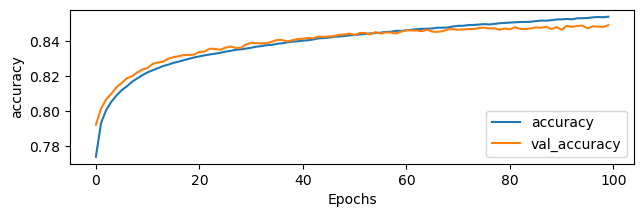

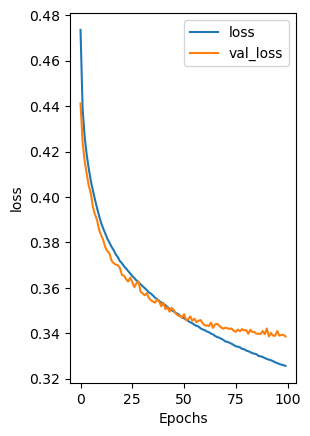

In [24]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

12508/12508 [==============================] - 217s 17ms/step - loss: 0.3286 - accuracy: 0.8517
Test Loss: 0.3286498188972473
Test Accuracy: 0.8516935110092163
              precision    recall  f1-score   support

           0       0.91      0.88      0.90    296236
           1       0.70      0.76      0.73    103996

    accuracy                           0.85    400232
   macro avg       0.80      0.82      0.81    400232
weighted avg       0.86      0.85      0.85    400232

rf auc : 0.9145505433875447


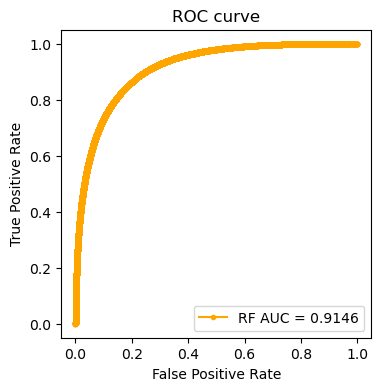

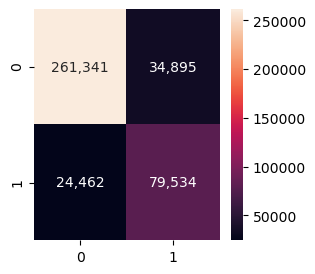

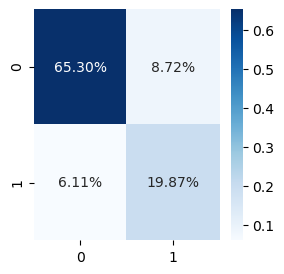

In [25]:
test_loss, test_acc = model_high.evaluate([ms2_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([ms2_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([ms2_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [27]:
test_pc

,peptide,En,Ec,E1,E2,protein,PEP,CHARGE,MS2,ID
0,K.GCIFLDSCTGVVQNNR.L,EKISKEPKGCIFLDS,TGVVQNNRLRKYAFE,-,-,sp|Q96BY6|DOC10_HUMAN,GCIFLDSCTGVVQNNR,2,0.099378206;0.08571642;0.23745453;0.4806975830...,1
1,K.GCIFLDSCTGVVQNNR.L,EKISKEPKGCIFLDS,TGVVQNNRLRKYAFE,-,-,sp|Q96BY6|DOC10_HUMAN,GCIFLDSCTGVVQNNR,3,0.10105045;0.0496183491;0.17540048;0.598226816...,0
2,K.GCIFLDSCTGVVQNNR.L,EKISKEPKGCIFLDS,TGVVQNNRLRKYAFE,-,-,sp|Q96BY6|DOC10_HUMAN,GCIFLDSCTGVVQNNR,4,0.114138655;0.055285938;0.21473199550000002;0....,0
3,K.MYNGSVPFEER.I,GIFPDIYKMYNGSVP,GSVPFEERILAVLQW,-,-,sp|P22413|ENPP1_HUMAN,MYNGSVPFEER,1,0.08776566;0.067099521;0.036628924;0.05993652;...,0
4,K.MYNGSVPFEER.I,GIFPDIYKMYNGSVP,GSVPFEERILAVLQW,-,-,sp|P22413|ENPP1_HUMAN,MYNGSVPFEER,2,0.07164742;0.10441995;0.022908453;0.028158737;...,1
...,...,...,...,...,...,...,...,...,...,...
400227,R.SDVWREFLDR.F,LAIGNGIRSDVWREF,VWREFLDRFGNIKVC,GIRSDVWREFLDRFG,-,sp|Q9Y2P4|S27A6_HUMAN,SDVWREFLDR,1,0.71818589;0.11173443;0.6187248599999999;1.451...,0
400228,R.SDVWREFLDR.F,LAIGNGIRSDVWREF,VWREFLDRFGNIKVC,GIRSDVWREFLDRFG,-,sp|Q9Y2P4|S27A6_HUMAN,SDVWREFLDR,2,0.9200228199;0.075766476;0.07199726029999999;0...,0
400229,R.SDVWREFLDR.F,LAIGNGIRSDVWREF,VWREFLDRFGNIKVC,GIRSDVWREFLDRFG,-,sp|Q9Y2P4|S27A6_HUMAN,SDVWREFLDR,3,0.3135493152;0.0442358692;0.061362298669999996...,0
400230,K.ADPENIK.S,ETEQNKKKADPENIK,KADPENIKSEGDGTQ,-,-,sp|Q5UIP0|RIF1_HUMAN,ADPENIK,1,0.24824446;0.31123823;0.5067087400000001;0.185...,0


In [28]:
test_pc['ms2_prob'] = probs

acc:  0.8311242462236551
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     66996
           1       0.83      0.83      0.83     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992

rf auc : 0.909842552361458


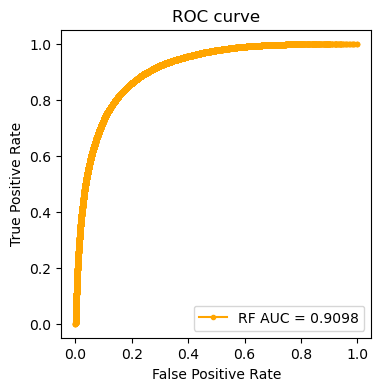

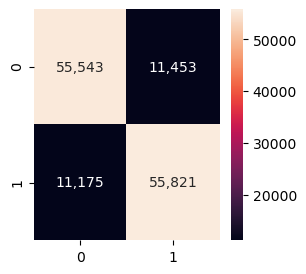

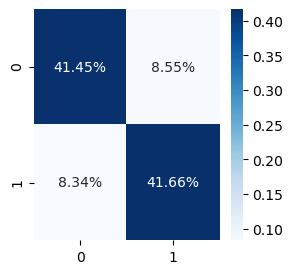

In [29]:
test_result = dict()
for p, nterm ,cterm, m1, m2, prot, pep, c, ms2, lab, ms2_prob in test_pc.values:
    row = (p, nterm, cterm, m1, m2, prot, pep)
    if row not in test_result:
        test_result[row] = dict()
    test_result[row][c]=ms2_prob

test_label = dict()
for prow, prob_dic in test_result.items():
    prob_arr = list(test_result[prow].values())
    ms2_prob = max(prob_arr)
    test_label[prow] = ms2_prob

test['ms2_ID'] = list(test_label.values())

y_test = test.ID.values
y_pred = [1 if p >= 0.5 else 0 for p in test.ms2_ID.values]

tptn = sum([1 for yt, yp in zip(y_test, y_pred) if yt==yp])
print('acc: ', tptn/len(y_test))
print(classification_report(y_test, y_pred))

probs = test.ms2_ID.values
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [199]:
# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_high.save("compareModel/2021KSBi_multi_ms2/")

# # It can be used to reconstruct the model identically.
# model_high_re = keras.models.load_model("compareModel/2021KSBi_multi_ms2/")